In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
from tqdm import tqdm
import sys
sys.path.append('/home/icb/manuel.gander/Atl/notebooks/')
import utils
utils = importlib.reload(utils)
import scipy


import warnings
from scipy.stats import ConstantInputWarning
from sklearn.exceptions import ConvergenceWarning

# Ignore ConstantInputWarning
warnings.filterwarnings("ignore", category=ConstantInputWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.linear_model import ElasticNet

In [3]:
alpha = 1
l1_ratio = 0.9
data='atl_only_phos'
#data='RNA'
kn = 10**6
source = 'MR_NCI60'

reps=50

In [4]:
D_prot, features, celllines = utils.load_dataset(data)
dfv = utils.prep_viability_AUCs2(D_prot)
dfv = dfv[dfv['Source']==source].copy()

100%|████████████████████████████████████████████████████████████████████████████████████| 1352726/1352726 [00:00<00:00, 1366299.40it/s]


In [5]:
drug = '10127622'

In [6]:
dfvs=dfv[dfv['PubChem_CID']==drug].copy()

In [7]:
len(dfvs['Cello'])

61

In [8]:
D_holdout = utils.get_holdouts_balanced(dfvs, reps)

In [67]:
ws = []
yts = []
yps = []
for hs in range(reps):
    holdouts=D_holdout[hs]
    dfv0, dfh=utils.split_of_validation_cell_lines(dfvs, ccls=holdouts)
    train_input=utils.dfv_to_train_arrays(dfv0, D_prot)
    mean = train_input[1].mean()

    rss1 = utils.paerson_nb(train_input[0], train_input[1])

    hold_input=utils.dfv_to_train_arrays(dfh, D_prot)
    
    if kn<len(rss1):
        r_kept=np.argsort(rss1)[-kn:]
        X_kept=train_input[0][:,r_kept]
        Xh_kept=hold_input[0][:,r_kept]
    else:
        #print('all kept')
        X_kept=train_input[0]
        Xh_kept=hold_input[0]
    y_train=train_input[1]
    y_test = hold_input[1]
                                  
    regr = ElasticNet(random_state=0, alpha=alpha, l1_ratio=l1_ratio)
    regr.fit(X_kept, y_train)
    
    prediction = regr.predict(Xh_kept)
    yts.append(y_test)
    yps.append(prediction)
    ws.append(regr.coef_)

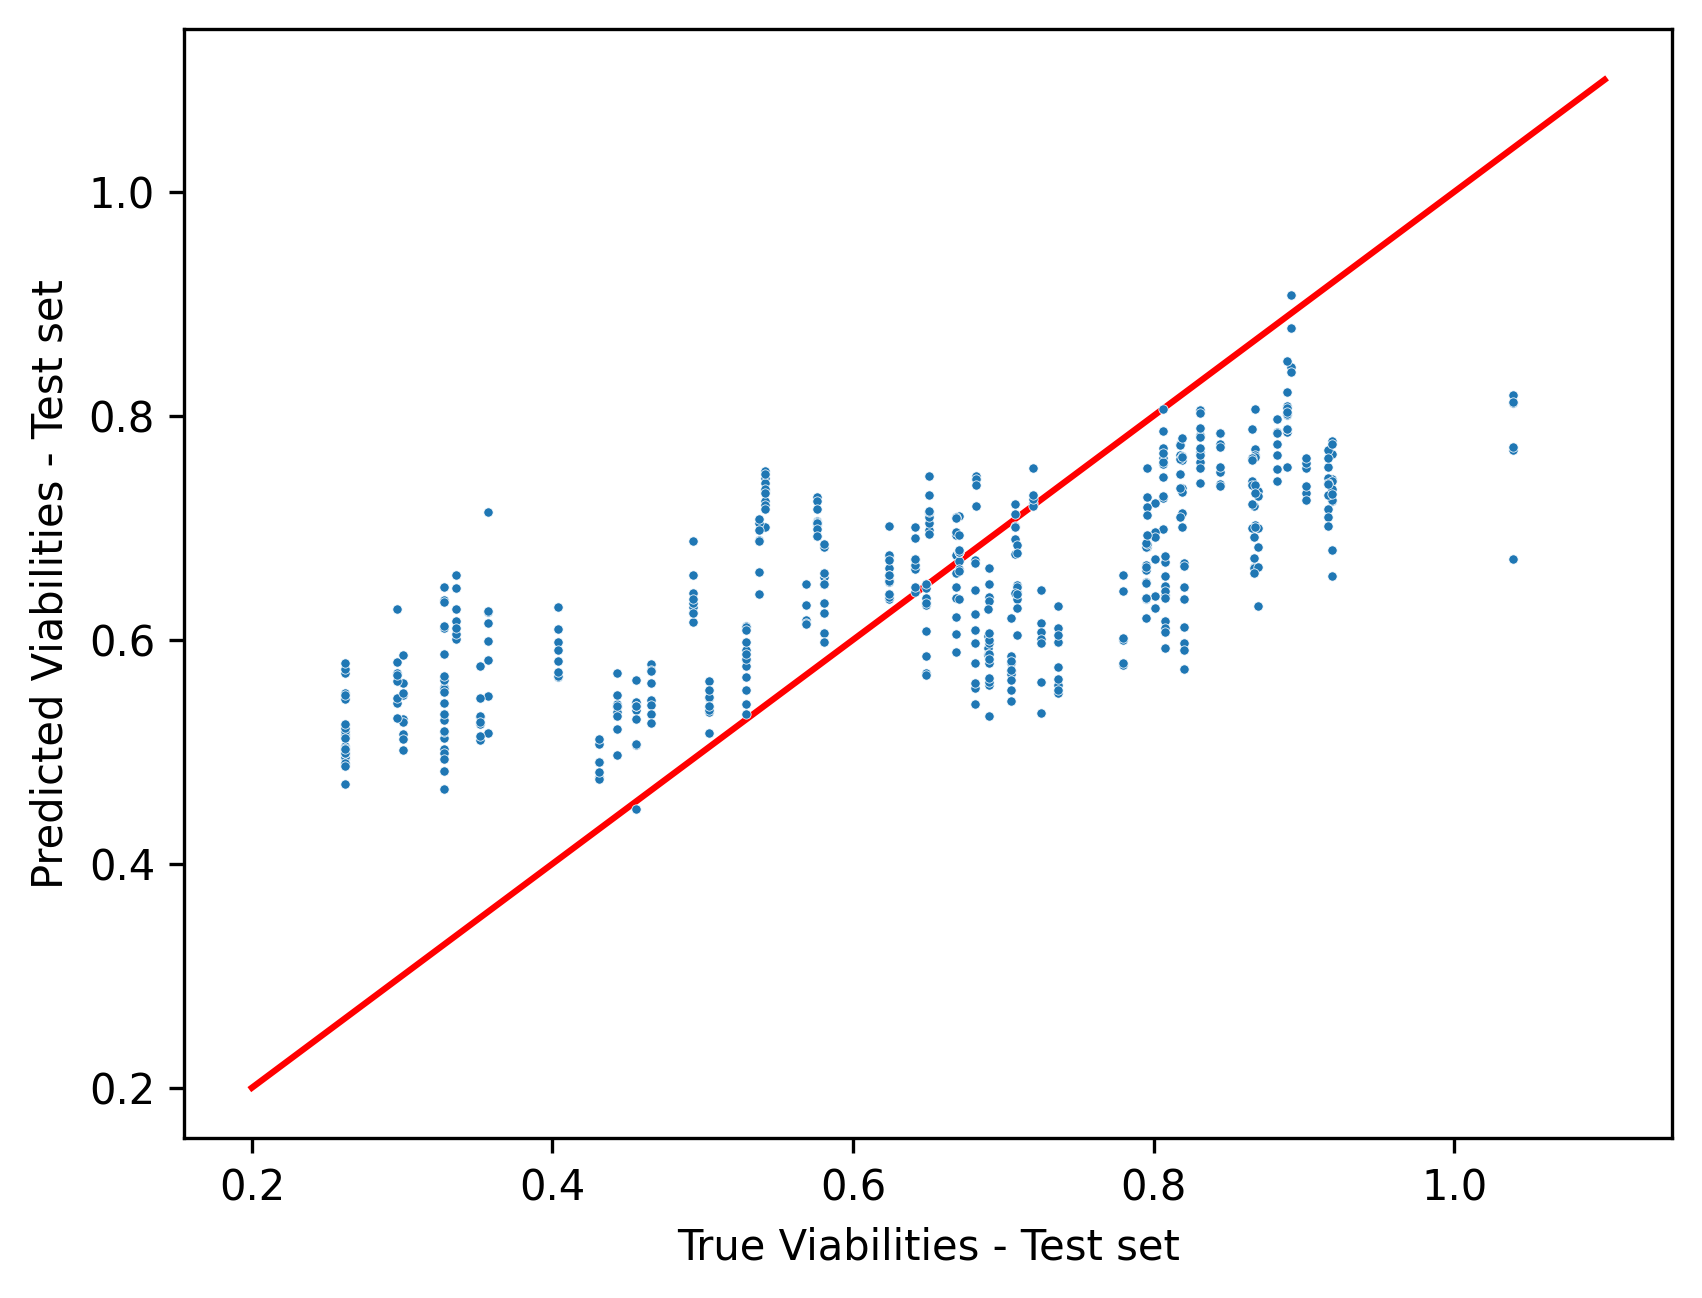

In [69]:
sns.scatterplot(x=np.concatenate(yts), y=np.concatenate(yps), s=5)
plt.xlabel('True Viabilities - Test set')
plt.ylabel('Predicted Viabilities - Test set')
plt.plot([0.2,1.1], [0.2,1.1], c='r', zorder=-1)

In [70]:
scipy.stats.pearsonr(np.concatenate(yts), np.concatenate(yps))

PearsonRResult(statistic=0.7495463781867587, pvalue=8.060656191260353e-99)

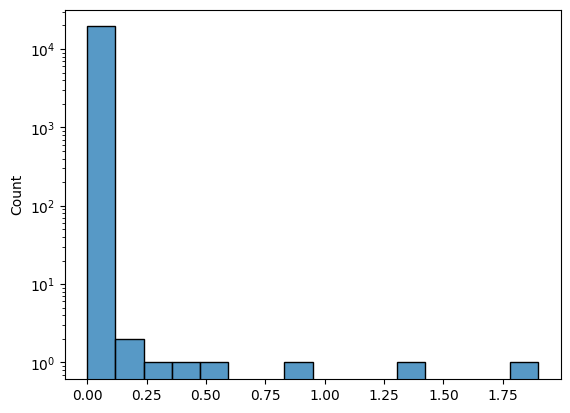

In [14]:
W = np.vstack(ws)
W = pd.DataFrame(data=W, columns = features)
sns.histplot(list(abs(W).sum()))
plt.yscale('log')
vc = abs(W).sum()

<Axes: >

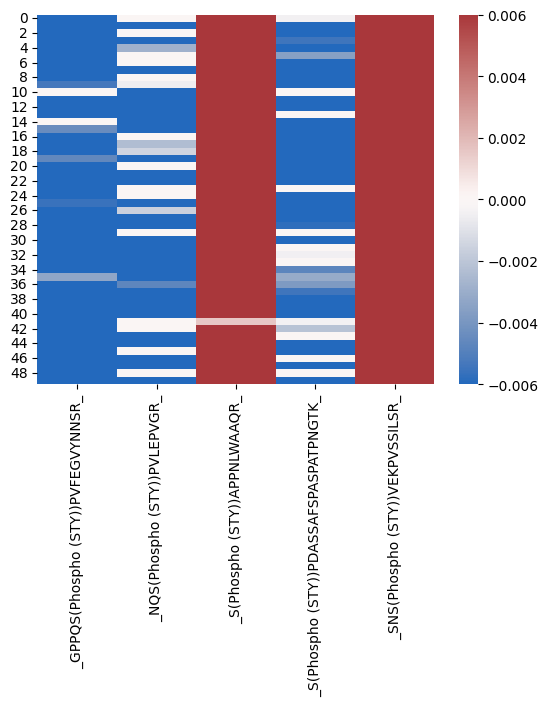

In [52]:
Ws = W[vc[vc>0.3].index]
lims = 0.006
sns.heatmap(Ws, cmap='vlag', vmin=-lims, vmax=lims)

In [38]:
dfd = pd.read_pickle('/home/icb/manuel.gander/Atl/data/Phosphopeptides_to_psites.pkl')

In [48]:
dfds = dfd[dfd['Modified sequence'].isin(Ws.columns)].copy()
dfds['Gene name'] = [a.split(';')[0] for a in dfds['Gene names']]
dfds['spos'] = [a.split(';')[0].split('_')[1] for a in dfds['Site positions']]
dfds['gsp'] = dfds['Gene name']+'_'+dfds['spos']
dfds

,Modified sequence,Proteins,Gene names,Start positions,End positions,Site sequence context,Site positions,PSP Kinases,gsp,Gene name,spos
1778678,_GPPQS(Phospho (STY))PVFEGVYNNSR_,Q8WWM7,ATXN2L,106,122,IGSARGQSTGKGPPQsPVFEGVYNNSRMLHF,Q8WWM7_S111,,ATXN2L_S111,ATXN2L,S111
3601706,_NQS(Phospho (STY))PVLEPVGR_,P51812,RPS6KA3,712,723,KGAMAATYSALNRNQsPVLEPVGRSTLAQRR,P51812_S715,,RPS6KA3_S715,RPS6KA3,S715
4294011,_S(Phospho (STY))APPNLWAAQR_,Q92934,BAD,98,109,EGMGEEPSPFRGRSRsAPPNLWAAQRYGREL,Q92934_S99,ARAF;Akt1;BRAF;PAK1;PKACA;PKCE;PKCI;PKCT;PRKD1...,BAD_S99,BAD,S99
4689673,_SNS(Phospho (STY))VEKPVSSILSR_,Q9UI08,EVL,328,342,PNSSEAGRKPWERSNsVEKPVSSILSRTPSV,Q9UI08_S331,,EVL_S331,EVL,S331
4705850,_S(Phospho (STY))PDASSAFSPASPATPNGTK_,Q53GS7,GLE1,87,107,STSASALDQPSFVPKsPDASSAFSPASPATP,Q53GS7_S88,ERK1;ERK2;GSK3B;JNK1,GLE1_S88,GLE1,S88


In [63]:
dfds['PSP Kinases'].iloc[2]

'ARAF;Akt1;BRAF;PAK1;PKACA;PKCE;PKCI;PKCT;PRKD1;RAF1;RSK2'

In [72]:
Ws.columns 

Index(['ATXN2L_S111', 'RPS6KA3_S715', 'BAD_S99', 'GLE1_S88', 'EVL_S331'], dtype='object')

In [ ]:
ATXN2L_S111, RPS6KA3_S715, and GLE1_S88

In [49]:
D_gene_site_dict = dict(zip(dfd['Modified sequence'], dfd['gsp']))

In [53]:
Ws.columns = Ws.columns.map(D_gene_site_dict)

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'ATXN2L_S111'),
  Text(1.5, 0, 'RPS6KA3_S715'),
  Text(2.5, 0, 'BAD_S99'),
  Text(3.5, 0, 'GLE1_S88'),
  Text(4.5, 0, 'EVL_S331')])

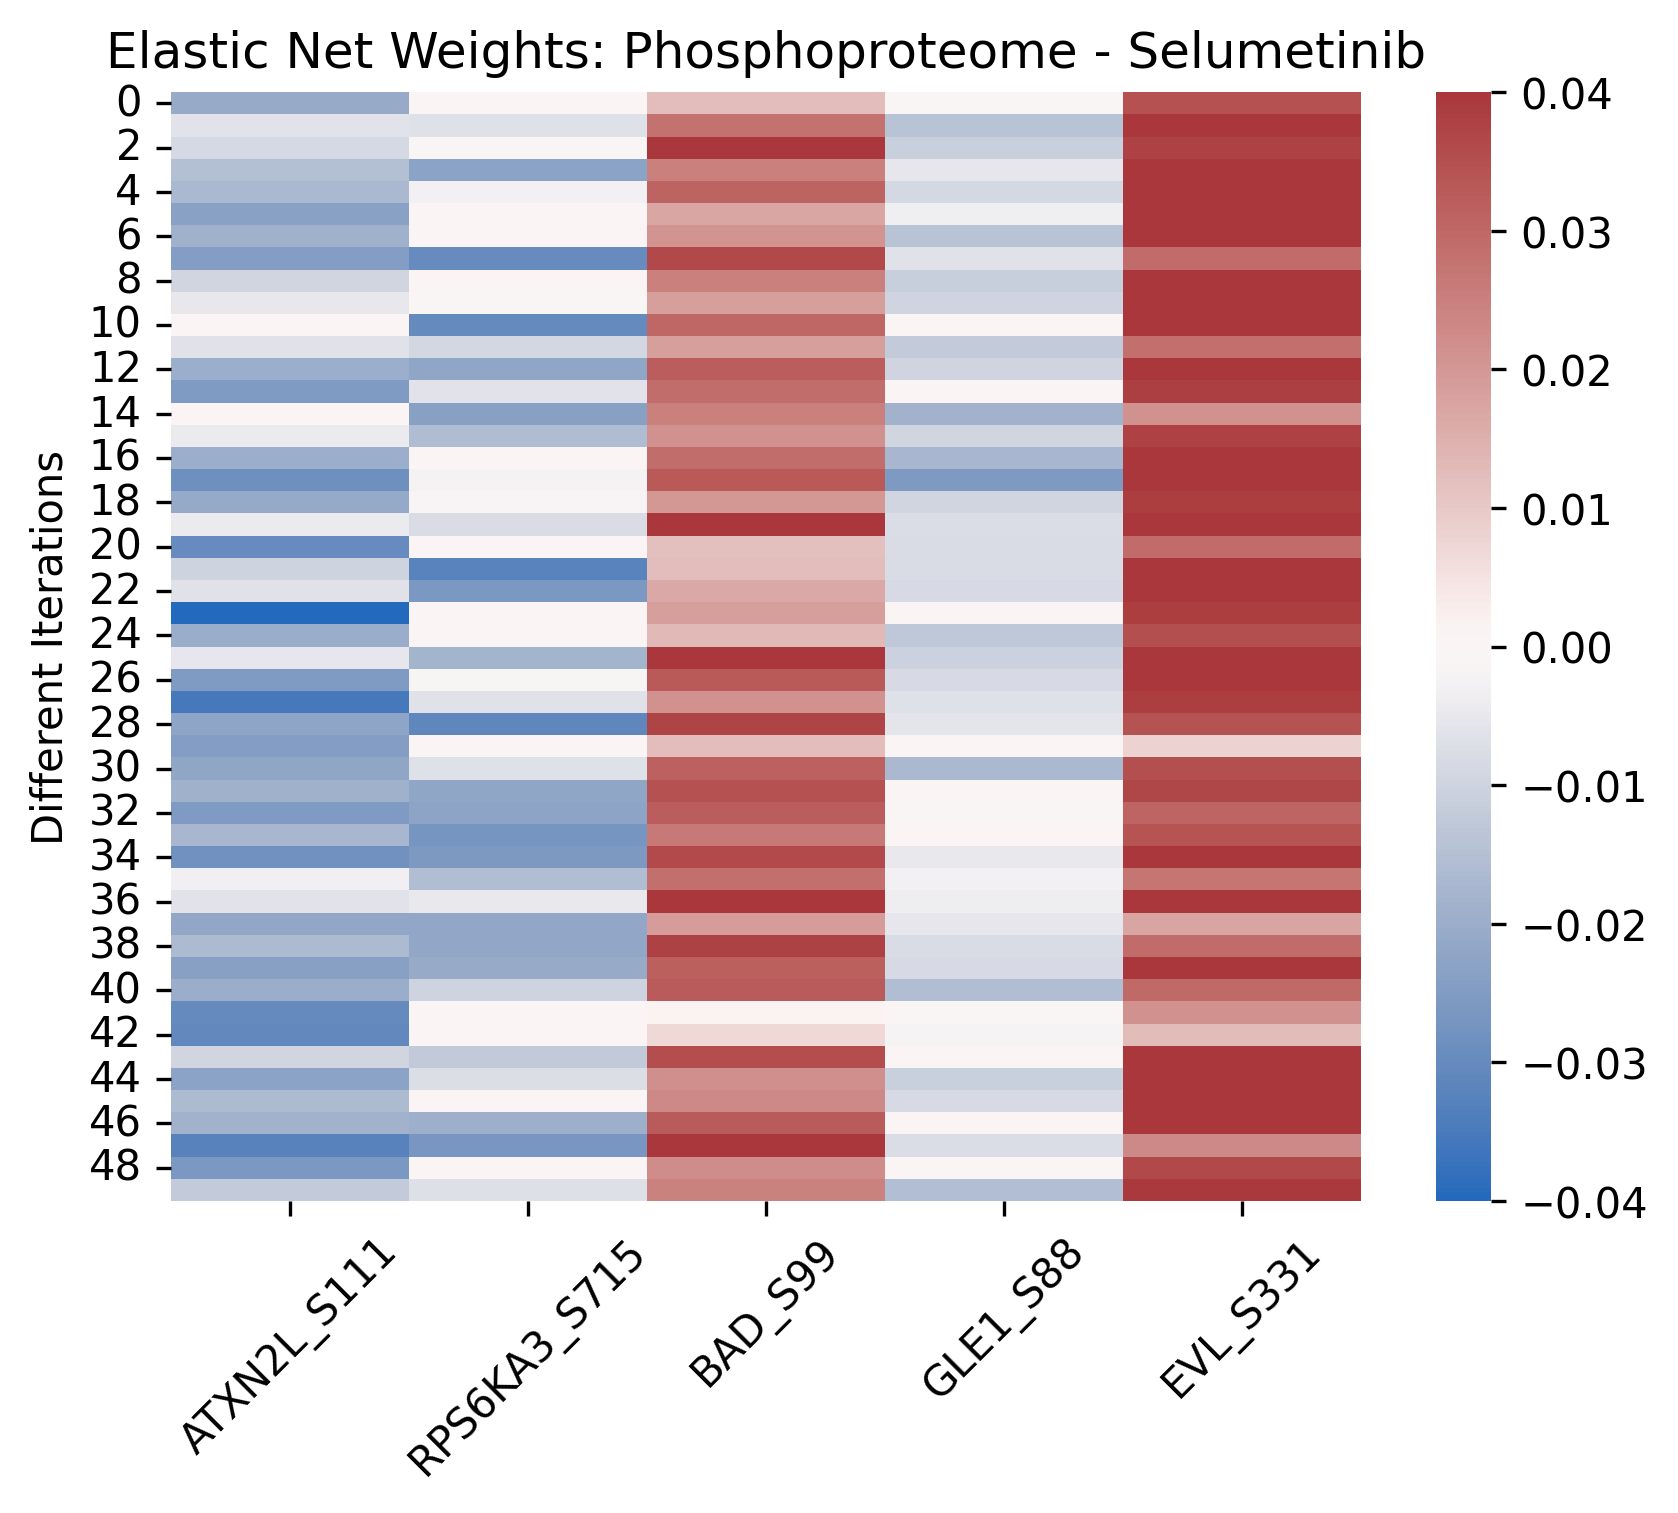

In [66]:
plt.rcParams['figure.dpi'] = 300
lims = 0.04
sns.heatmap(Ws, cmap='vlag', vmin=-lims, vmax=lims)
plt.ylabel('Different Iterations')
plt.title('Elastic Net Weights: Phosphoproteome - Selumetinib')
plt.xticks(rotation=45)

In [ ]:
 By selectively targeting MEK1 and MEK2, selumetinib is able to inhibit oncogenic downstream effects of the Raf-MEK-ERK signaling pathway, which is often